## Intro to the Notebook:<br>
- I will be Showing the implementation of **logistic regression** in binary classification problem<br>
- The main goal is to understand the reasoning behind employee turnover and to come up with a model to classify an employee’s risk of attrition.
- A recommendation for a retention plan was created, which incorporates some best practices for employee retention at different risk levels of attrition.


## Intro to the dataset:<br>
link to the dataset : https://www.kaggle.com/ludobenistant/hr-analytics/data<br><br>

Why are our best and most experienced employees leaving prematurely? Have fun with this database and try to predict which valuable employees will leave next. Fields in the dataset include:<br><br>

- Satisfaction Level
- Last evaluation
- Number of projects
- Average monthly hours
- Time spent at the company
- Whether they have had a work accident
- Whether they have had a promotion in the last 5 years
- Departments (column sales)
- Salary
- Whether the employee has left


In [42]:
%matplotlib inline

In [43]:
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# 1.EDA:
<br>
### Goals for EDA-
- Our EDA process will start with getting familiar with the types of data we have in each column.
- Taking a look at null values, as this dataset is clean we wont have null values to deal with.
- we will rename the coloumns for better understanding and ease of working.
- Get a statiscal overview of the data.

In [81]:
dataset = pd.read_csv("HR_comma_sep.csv")
dataset.head(3)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium


In [46]:
dataset.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
sales                    False
salary                   False
dtype: bool

In [47]:
df = dataset.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_project': 'projectCount',
                        'average_montly_hours': 'averageMonthlyHours',
                        'time_spend_company': 'yearsAtCompany',
                        'Work_accident': 'workAccident',
                        'promotion_last_5years': 'promotion',
                        'sales' : 'department',
                        'left' : 'turnover'
                        })

In [48]:
turnover=df.turnover
df.drop("turnover",axis=1,inplace=True)

df.insert(0,'turnover',turnover)

In [49]:
df.head(3)

,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion,department,salary
0,1,0.38,0.53,2,157,3,0,0,sales,low
1,1,0.80,0.86,5,262,6,0,0,sales,medium
2,1,0.11,0.88,7,272,4,0,0,sales,medium


# Stats overview:

In [50]:
df.dtypes

turnover                 int64
satisfaction           float64
evaluation             float64
projectCount             int64
averageMonthlyHours      int64
yearsAtCompany           int64
workAccident             int64
promotion                int64
department              object
salary                  object
dtype: object

<br>
Lets take a look at the percentage of employees who left vs stayed:
we see that **76% stayed** while approx **24% left** 

In [51]:
df.turnover.value_counts()/len(df)

0    0.761917
1    0.238083
Name: turnover, dtype: float64

In [52]:
df.groupby("turnover").mean()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
turnover,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


### Correlation and heatmap:<br>
<font size=3>
Heat maps visualize correlation between various features in our analysis, We see two types of correlation over here:
</font>
- Positive correlation between:
    - Evaluation / Project_count
    - Evaluation / Average_monthly_hours
    - Project_count / Average_monthly_hours
    
    
- Neagtive correlation between:
    - Turnover / Satisfaction


,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
turnover,1.000000,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,-0.061788
satisfaction,-0.388375,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,0.025605
evaluation,0.006567,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,-0.008684
projectCount,0.023787,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,-0.006064
averageMonthlyHours,0.071287,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,-0.003544
yearsAtCompany,0.144822,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.067433
workAccident,-0.154622,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,0.039245
promotion,-0.061788,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,1.000000


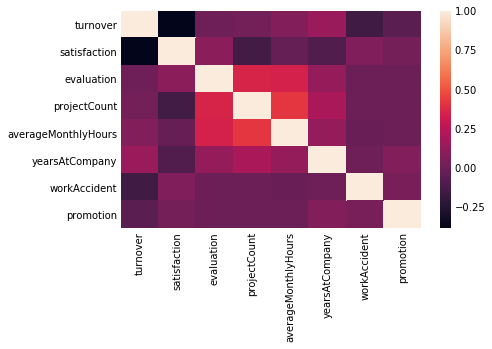

In [53]:
corr = df.corr()

sns.heatmap(corr)
corr

# Stats test for corr

### one sample t-test(we'll measure satisfaction level)

- **Null hypo:** no difference in satisfaction b/w employees who had turnover vs no turnover
- **Alt hypo:** there is a diff.
<br><br>
Let's conduct a t-test at 95% confidence level and see if it correctly rejects the null hypothesis that the sample comes from the same distribution as the employee population. To conduct a one sample t-test, we can use the stats.ttest_1samp() function:

In [54]:
print df.satisfaction[df.turnover==0].mean()
print df.satisfaction[df.turnover==1].mean()

0.66680959048
0.440098011761


In [55]:
import scipy.stats as stats

stats.ttest_1samp(a= df.satisfaction[df.turnover==1], # sample of Employee satisfaction who had a turnover,
popmean= df.satisfaction[df.turnover==0].mean()
)

Ttest_1sampResult(statistic=-51.3303486754725, pvalue=0.0)

In [82]:
dof = len(df[df.turnover==1])

print stats.t.ppf(0.025,dof) # 2.5% at head
print stats.t.ppf(0.975,dof) # 2.5% at tail


-1.9606285216
1.9606285216


### Result for the t-test:
<br>
The result for t-statistic is **-51.3303486754725**<br>
The t-critical value is **-1.96(tail) & 1.96(head)**<br>
<br>
looking at these results we can safely reject the null hypothesis.<br><br>



# 2. Analysis:

### Lets visualize some distributions:
### Observations:
- we can see that evaluation and averagemonthlyhours have bipolar distribution.
- People with low salary are most probable to leave the job
- One intresting thing that we observe over here is that people wiht higher salaries have left too... we can assume that they might have recieved an offer for a better job with better salary.. may be ?


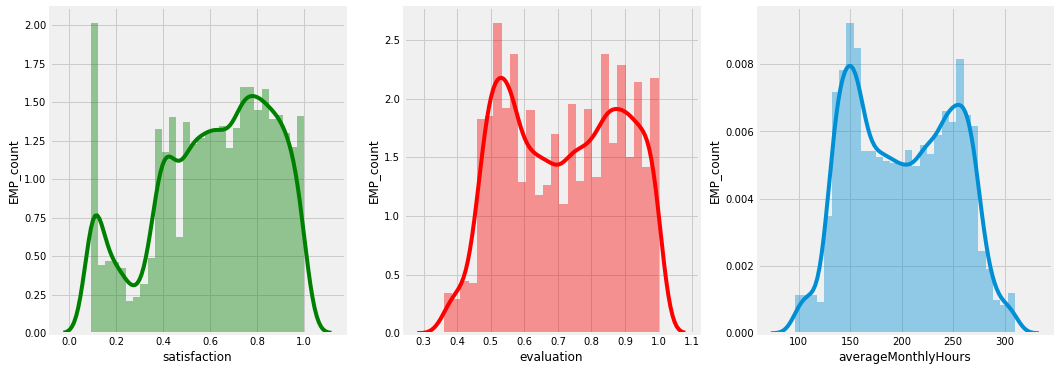

In [57]:
f,ax = plt.subplots(ncols=3,figsize=(16,6))

p1 = sns.distplot(df.satisfaction,ax=ax[0],color='g')
p2 = sns.distplot(df.evaluation,ax=ax[1],color='r')
p3 = sns.distplot(df.averageMonthlyHours)

p1.set_ylabel("EMP_count")
p2.set_ylabel("EMP_count")
p3.set_ylabel("EMP_count")

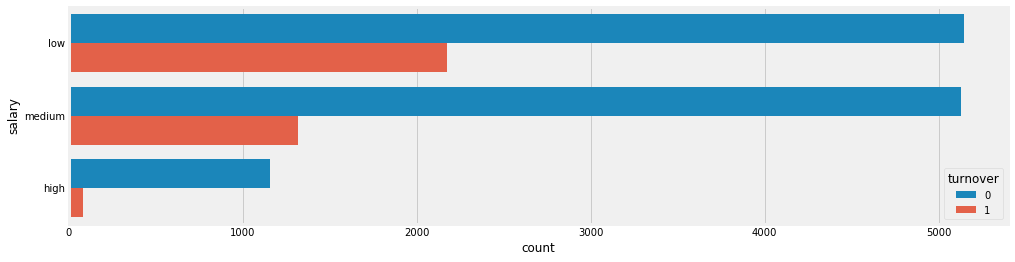

In [58]:
f,ax = plt.subplots(figsize=(15,4))

sns.countplot(y=df.salary,hue=df.turnover)

### Which departments have higher turnovers ?

On plotting we see that these departments have the most turnovers:
- Sales
- Technical
- Support
<br><br>

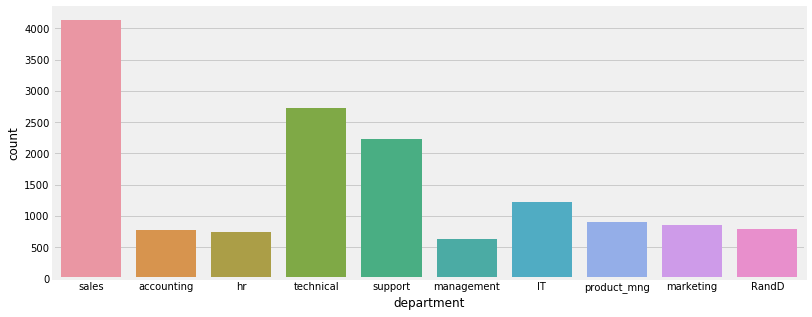

In [59]:
f,ax = plt.subplots(figsize=(12,5))
sns.countplot(x=df.department,ax=ax)

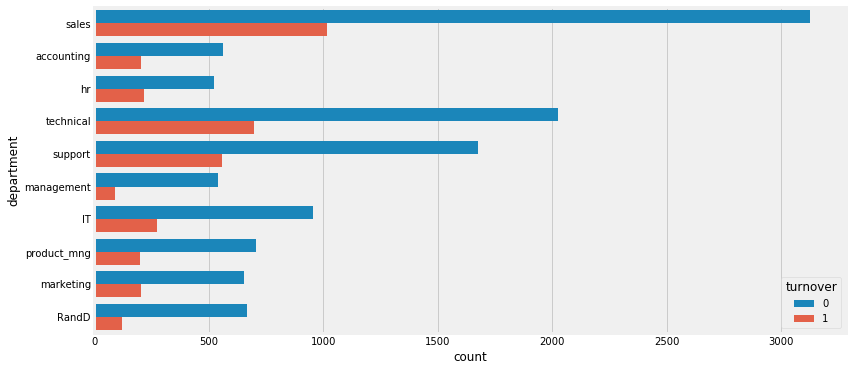

In [60]:
f,ax = plt.subplots(figsize=(12,6))

sns.countplot(y=df.department,hue=df.turnover)

<br>
<font size =3>
On analysing project_count we see that it also has a drastic influence over turnovers.. We can make these observations from the graph below:
</font>
- Employees with very high or very low workloads are most probable of exhibiting turnover.
- All employees with **7 projects** left the company.
- The sweet spot for avoiding high employee turnover seems to be 3 to 4 projects.

**Questions and Assumptions that can be formulated over here are:**
- Employees with very high project counts are really unhappy and stressed.
- We see that employees that were given low projects also left, might be this made them feel like they are not considered good employee or their growth is being hindered and hence they left ?

<br>
On analyising the **number of years** the employee had stayed in the company.. we see that employees in their **3rd to 5th** year need the most attention as they are most probable of leaving the company.

<br>

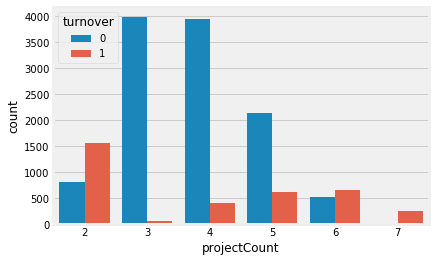

In [61]:
sns.countplot(x=df.projectCount,hue=df.turnover)

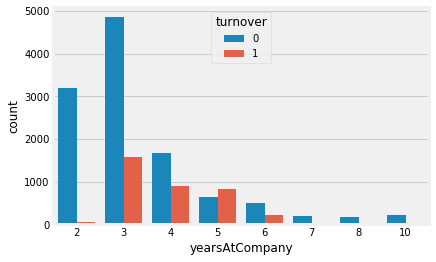

In [64]:
sns.countplot(x=df.yearsAtCompany,hue=df.turnover)

<br>
<br>
<font size=3>
The plot below is the most compelling peice of information up until now, We can clearly see there are three clusters, based on their locations we can name them as:
</font>

- Hardworking and sad
- Low performance and sad
- Hardworking and happy
<br><br>
third cluster seems to be the one where we can assume that the employee found a better job opportunity
<br><br>

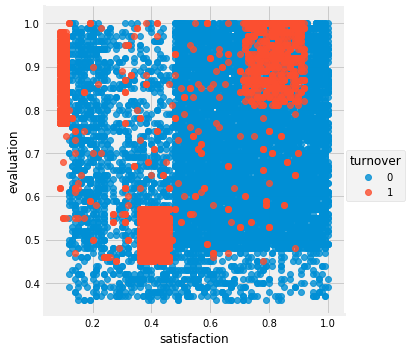

In [63]:
sns.lmplot(x="satisfaction",y='evaluation',data=df,fit_reg=False,hue="turnover")

<br>
# 3. Predictive Modelling:
<br>
- As we can clearly see the clusters we can create a predictive model using **K-MEANS clustering** algorithm
- We will also use **Decision Trees** to find the **most important features (FEATURE SELECTION)** that will influence the prediction most

**Workflow:**
- The decision tree gives us three most important features:
    - satisfaction 
    - evaluation 
    - yearsAtCompany
- We will use these features for training our Logistic Regression model
<br><br>

In [65]:
from sklearn.cluster import KMeans

In [66]:
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(df[df.turnover==1][["satisfaction",'evaluation']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=2, tol=0.0001, verbose=0)

In [67]:
colours = ['green' if c==0 else 'blue' if c==1 else 'red'for c in kmeans.labels_]

In [68]:
kmeans.cluster_centers_

array([[ 0.80851586,  0.91170931],
       [ 0.41014545,  0.51698182],
       [ 0.11115466,  0.86930085]])

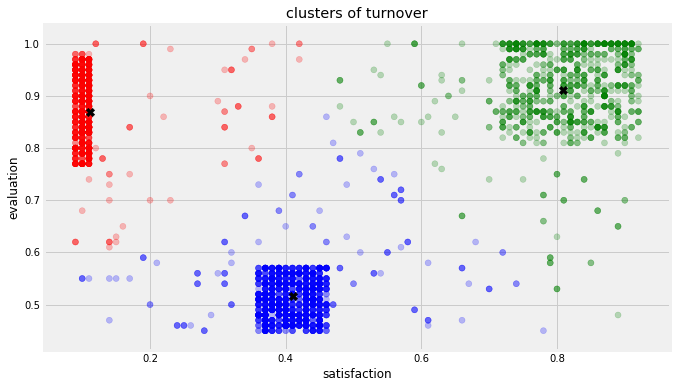

In [69]:
f,ax = plt.subplots(figsize=(10,6))

plt.scatter(x = 'satisfaction',y= 'evaluation', data = df[df.turnover==1], c = colours, alpha = 0.25)
plt.scatter(x= kmeans.cluster_centers_[:,0], y= kmeans.cluster_centers_[:,1],marker='X',c='black',s=70)

plt.xlabel('satisfaction')
plt.ylabel('evaluation')
plt.title('clusters of turnover')

**K-Means generates three clusters which represent the three categories we mentioned before:**
<br>Now lets implement the decision tree classifier for **feature selection**

In [70]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [71]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)

In [73]:
#Converting to categorical variable
df["department"] = df["department"].astype('category').cat.codes
df["salary"] = df["salary"].astype('category').cat.codes

In [74]:
# Create train and test splits

target_name = 'turnover'
X = df.drop('turnover', axis=1)
y=df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=123, stratify=y)


In [75]:
dtree = tree.DecisionTreeClassifier(
    #max_depth=3,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train,y_train)

In [76]:
## plot the importances ##
importances = dtree.feature_importances_
feat_names = df.drop(['turnover'],axis=1).columns

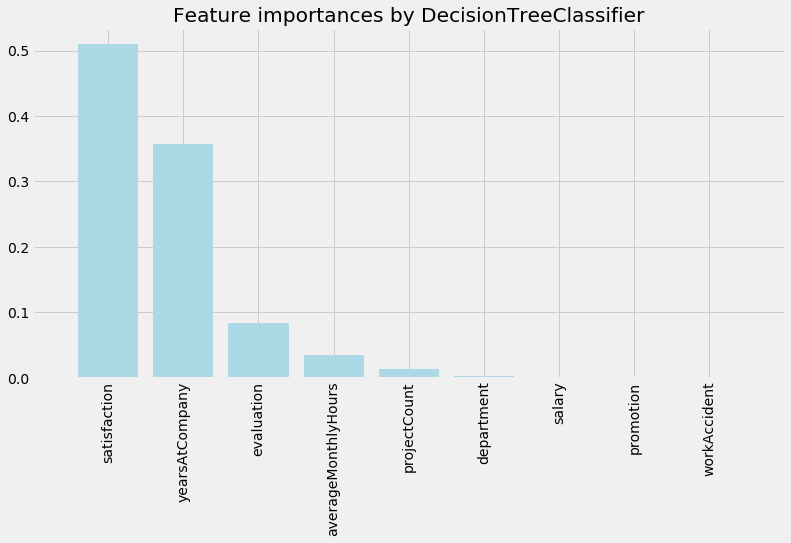

In [77]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()



In [78]:
# Import the neccessary modules for data manipulation and visual representation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [80]:
# Create an intercept term for the logistic regression equation
df['int'] = 1
indep_var = ['satisfaction', 'evaluation', 'yearsAtCompany', 'int', 'turnover']
df = df[indep_var]

# Create train and test splits
target_name = 'turnover'

X = df.drop('turnover', axis=1)
y=df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=123, stratify=y)

X_train.head()

,satisfaction,evaluation,yearsAtCompany,int
9003,0.59,1.00,3,1
5697,0.81,0.98,2,1
10691,1.00,0.93,2,1
1884,0.87,0.91,5,1
13572,0.87,0.48,3,1


In [93]:
import statsmodels.api as sm
iv = ['satisfaction','evaluation','yearsAtCompany', 'int']

logReg = sm.Logit(y_train, X_train)
answer = logReg.fit()

Optimization terminated successfully.
         Current function value: 0.467233
         Iterations 6


In [96]:
answer.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               turnover   No. Observations:                12749
Model:                          Logit   Df Residuals:                    12745
Method:                           MLE   Df Model:                            3
Date:                Mon, 06 Nov 2017   Pseudo R-squ.:                  0.1487
Time:                        21:41:51   Log-Likelihood:                -5956.7
converged:                       True   LL-Null:                       -6997.0
                                        LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
satisfaction      -3.7690      0.095    -39.564      0.000      -3.956      -3.582
evaluation         0.2076      0.133      1.565      0.118      -0.052       0.468
yearsAtCompany     0.1701      0.015     11.342      0.000       0.141       0.200
int                0.1819      0.113      1.613      0.107      -0.039       0.403
==================================================================================
"""

In [99]:
answer.params

satisfaction     -3.769022
evaluation        0.207596
yearsAtCompany    0.170145
int               0.181896
dtype: float64

----------------------------------------------------------------------------------------------------------------
**Coef:**

A regression coefficient describes the size and direction of the relationship between a predictor and the response variable. Coefficients are the numbers by which the values of the term are multiplied in a regression equation. 

**Interpretation:**

We use the coefficient to determine whether a change in a predictor variable makes the event more likely or less likely

----------------------------------------------------------------------------------------------------------------

We’ll be using the three most important features to create our model: Satisfaction, Evaluation, and YearsAtCompany.
 
Following overall equation can be developed:


**Employee Turnover Score** = **Satisfaction***(-3.769022) + **Evaluation***(0.207596) + **YearsAtCompany***(0.170145) + 0.181896

The values above are the coefficient assigned to each independent variable. The constant 0.181896 represents the effect of all uncontrollable variable

In [101]:
# Creating a function to compute coefficients
coef = answer.params

def y (coef, Satisfaction, Evaluation, YearsAtCompany) : 
    return coef[3] + coef[0]*Satisfaction + coef[1]*Evaluation + coef[2]*YearsAtCompany


In [102]:
# showing working :
# An Employee with 0.7 Satisfaction and 0.8 Evaluation and worked 3 years has a 14% chance of turnover

y1 = y(coef, 0.7, 0.8, 3)
p = np.exp(y1) / (1+np.exp(y1))
p

0.14431462559738251


# Intepretation of Score
-------------------------------------------------------------------------------------------------------------------------

If you were to use these employee values into the equation:

    Satisfaction: 0.7
    Evaluation: 0.8
    YearsAtCompany: 3

You would get:

Employee Turnover Score = (0.7)(-3.769022) + (0.8)(0.207596) + (3)(0.170145) + 0.181896 = 0.14431 = 14%

**Result:** This employee would have a 14% chance of leaving the company. This information can then be used to form our retention plan.


<br>
## Retention Plan Using Logistic Regression
--------------------------------------------------------------

With the logistic regression model, we can now use our scores and evaluate the employees through different scoring metrics. Each zone is explain here:

**Safe Zone ( score < 20% )** – Employees within this zone are considered safe.<br>
**Low Risk Zone ( 20% < score < 60% )** – Employees within this zone are too be taken into consideration of potential turnover. This is more of a long-term track.<br>
**Medium Risk Zone ( 60% < score < 90% )** – Employees within this zone are at risk of turnover. Action should be taken and monitored accordingly.<br>
**High Risk Zone (90% < score)** – Employees within this zone are considered to have the highest chance of turnover. Action should be taken immediately.<br><br>

So with our example above, the employee with a 14% turnover score will be in the safe zone.



# Potential Solution
---

In our employee retention problem, rather than simply predicting whether an employee will leave the company within a certain time frame, we would much rather have an estimate of the probability that he/she will leave the company. We would rank employees by their probability of leaving, then allocate a limited incentive budget to the highest probability instances.

---
**Solution 1:**

We can rank employees by their probability of leaving, then allocate a limited incentive budget to the highest probability instances.

**Solution 2:**

Develop learning programs for managers. Then use analytics to gauge their performance and measure progress. Some advice:

   - Be a good coach
   - Empower the team and do not micromanage
   - Express interest for team member success
   - Have clear vision / strategy for team
   - Help team with career development

